#  🌍 Think global, Buy local : Analysis of Dataset content 🌍

> Open Food Facts is an open database of food products from around the world. We will use this dataset to study importation and exportation of food around the world.
Our analysis aims at making people aware of ecological concerns of food importation in France and hopefully changing ways of comsuptions towards a more sustainable food trade.

# Imports

In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
import json,folium,unidecode,branca
import branca.colormap as cm
import matplotlib.pyplot as plt
from geopy.distance import geodesic

%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import lower, col, count
from pyspark.sql.types import IntegerType

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Loading Data

In [2]:
data = spark.read.option("delimiter", "\t").option("header", "true").csv("data/en.openfoodfacts.org.products.csv")

# Data cleaning

## <font color=green> Data size and missing values </font>

>Let's first give a look at the total number of product and features to estimate the size of the dataset.

In [3]:
ntot = data.count()
columns = data.columns;
print('There are ',ntot, ' products listed described by ', len(columns), 'features in the dataframe')

There are  691256  products listed described by  173 features in the dataframe


> Dataset is relatively small, comprising of 1.2 * 10⁸ entries

In [4]:
#Estimate the sparsity of the matrix by counting missing values and null values
null_counts = data.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in data.columns))
zeros = null_counts.toPandas().values.sum()
print('There are %.2f missing values in the dataframe ' %(zeros))

There are 95879931.00 missing values in the dataframe 


> Missing values (and null values) account for more than 80% of the dataset. 
This is principally due to the large number of nutritionnal features, where many values are set to 0 if not present in the product, or simple not available.

>Let's now explore the different information provided by the dataset 'open food facts' for each product.

In [6]:
data.dtypes

[('code', 'string'),
 ('url', 'string'),
 ('creator', 'string'),
 ('created_t', 'string'),
 ('created_datetime', 'string'),
 ('last_modified_t', 'string'),
 ('last_modified_datetime', 'string'),
 ('product_name', 'string'),
 ('generic_name', 'string'),
 ('quantity', 'string'),
 ('packaging', 'string'),
 ('packaging_tags', 'string'),
 ('brands', 'string'),
 ('brands_tags', 'string'),
 ('categories', 'string'),
 ('categories_tags', 'string'),
 ('categories_en', 'string'),
 ('origins', 'string'),
 ('origins_tags', 'string'),
 ('manufacturing_places', 'string'),
 ('manufacturing_places_tags', 'string'),
 ('labels', 'string'),
 ('labels_tags', 'string'),
 ('labels_en', 'string'),
 ('emb_codes', 'string'),
 ('emb_codes_tags', 'string'),
 ('first_packaging_code_geo', 'string'),
 ('cities', 'string'),
 ('cities_tags', 'string'),
 ('purchase_places', 'string'),
 ('stores', 'string'),
 ('countries', 'string'),
 ('countries_tags', 'string'),
 ('countries_en', 'string'),
 ('ingredients_text', 'str

> As our project aims at exploring food importations, a lot of features are not of interest for our study.
We will focus on the following information:

## <font color=green> Selection of features </font>

- Food products names ['product_name']
- Code of the product ['code']
- url of the product ['url']
- Origin of the products ['origins']
- Countries where the food products are sold ['countries_en']
- Countries where the food products are manufactured ['manufacturing_places_tags']
- Food categories (i.e: meat, cheese, vegetables...) ['categories_tags']
- url of the image of the product ['image_url']
- Carbon foot print of the production ['carbon-footprint_100g']



> However, some columns are redundant and give the same information. We will next justify why we selected some columns rather than others.

###  <font color=blue> Selection of the origins </font>

>There are two redundant columns for information about origins of the products: 'origins', 'origins_tags'. Therefore, we calculate the number of non null values in each columns to select the one we will use for further analysis.

In [7]:
#origins
print('In the [origins] column, there are ', data.where(col("origins").isNull() == False).count(), 'non-null values')

In the [origins] column, there are  41700 non-null values


In [8]:
#origins_tags
print('In the [origins_tags] column, there are ', data.where(col("origins_tags").isNull() == False).count(), 'non-null values')

In the [origins_tags] column, there are  41646 non-null values


In [9]:
#Non null origins_tags values for null origins values
print('In the dataframe, there are ', data.where(col("origins").isNull()).where(col("origins_tags").isNull() == False).count(), \
      'products that have non-null values for [origins_tags] and null values for [origins]')

In the dataframe, there are  0 products that have non-null values for [origins_tags] and null values for [origins]


>We will therefore choose the 'origin' column, as every product that have an 'origins_tags' also have an 'origins'. The 'origins' column provides more information. 

###  <font color=blue> Selection of the countries where the product is sold  </font>

>There are three redundant columns for information about origins of the products: 'countries', 'countries_tags','countries_en'. 

In [10]:
#countries
print('In the [countries] column, there are ', data.where(col("countries").isNull() == False).count(), 'non-null values')

In the [countries] column, there are  690647 non-null values


In [11]:
#countries_tags
print('In the [countries_tags] column, there are ', data.where(col("countries_tags").isNull() == False).count(), 'non-null values')

In the [countries_tags] column, there are  690647 non-null values


In [12]:
#countries_en
print('In the [countries_en] column, there are ', data.where(col("countries_en").isNull() == False).count(), 'non-null values')

In the [countries_en] column, there are  690647 non-null values


>All the columns have exactly the same size. We choose 'countries_en' where countries are written in english for conveniency

###  <font color=blue> Selection of the manufacturing places   </font>

>There are two redundant columns for information about origins of the products: 'manufacturing_places' and 'manufacturing_places_tags'. 

In [13]:
#manufacturing_places
print('In the [manufacturing_places] column, there are ', data.where(col("manufacturing_places").isNull() == False).count(), 'non-null values')

In the [manufacturing_places] column, there are  66476 non-null values


In [14]:
#manufacturing_places_tags
print('In the [manufacturing_places_tags] column, there are ', data.where(col("manufacturing_places_tags").isNull() == False).count(), 'non-null values')

In the [manufacturing_places_tags] column, there are  66456 non-null values


>Once again, the columns have almost the same size. We selected the 'manufacturing_places_tags' column as the names are written in lower case in that column, that will make further analysis easier. 

### <font color=blue> Selection of the food categories  </font>

>There are three redundant columns for information about origins of the products: 'categories', 'categories_tags','categories_en'. 

In [15]:
#categories
print('In the [categories] column, there are ', data.where(col("categories").isNull() == False).count(), 'non-null values')

In the [categories] column, there are  178033 non-null values


In [16]:
#categories_tags
print('In the [categories_tags] column, there are ', data.where(col("categories_tags").isNull() == False).count(), 'non-null values')

In the [categories_tags] column, there are  178032 non-null values


In [17]:
#categories_en
print('In the [categories_en] column, there are ', data.where(col("categories_en").isNull() == False).count(), 'non-null values')

In the [categories_en] column, there are  177998 non-null values


In [18]:
#Showing counts for 'categories' column
data.filter(data.categories != "").groupBy("categories").count().sort("categories").show(5)

+--------------------+-----+
|          categories|count|
+--------------------+-----+
|,Réfrigérés,Choux...|    1|
|,en:cooking-helpe...|    1|
|                   .|    1|
|                   0|    1|
|0 azúcares añadidos.|    1|
+--------------------+-----+
only showing top 5 rows



In [19]:
#Showing counts for 'categories_tags' column
data.filter(data.categories_tags != "").groupBy("categories_tags").count().sort("categories_tags").show(5)

+--------------------+-----+
|     categories_tags|count|
+--------------------+-----+
| ,en:coconut-butters|    6|
|,en:coconut-macar...|    2|
|,en:coconut-macar...|    1|
|,en:coconut-macar...|    1|
|,en:cooking-helpe...|    4|
+--------------------+-----+
only showing top 5 rows



>The size of the different columns are similar, however, information in the category_tags seemed to be more meaningful and already more sorted into more general categories. Therefore, we selected the 'categories_tags' column. 

> Here is the final dataset on which we will perform further analysis. 

In [5]:
cols = ['code', 'url', 'product_name', 'categories_tags', 'origins', 'manufacturing_places_tags', 'countries_en', 'image_url', 'carbon-footprint_100g']
Data_products = data.select(*cols)
Data_products.show(5)

+-------------+--------------------+--------------------+---------------+-------+-------------------------+------------+---------+---------------------+
|         code|                 url|        product_name|categories_tags|origins|manufacturing_places_tags|countries_en|image_url|carbon-footprint_100g|
+-------------+--------------------+--------------------+---------------+-------+-------------------------+------------+---------+---------------------+
|0000000000017|http://world-en.o...|    Vitória crackers|           null|   null|                     null|      France|     null|                 null|
|0000000000031|http://world-en.o...|               Cacao|           null|   null|                     null|      France|     null|                 null|
|0000000000123|http://world-en.o...|Sauce Sweety chil...|           null|   null|                     null|      France|     null|                 null|
|0000000000291|http://world-en.o...|           Mendiants|           null|   null| 

## <font color=green> Data standardization </font>

In [21]:
Data_products

DataFrame[code: string, url: string, product_name: string, categories_tags: string, origins: string, manufacturing_places_tags: string, countries_en: string, image_url: string, carbon-footprint_100g: string]

>We would first like to standardize some columns of the dataframe to facilitate further analysis. 
All the names have to be put in lower cases. We also have to get rid of accents. We used unicode to do that. 
The function format_column_in_dataframe(Df, colu) allows to get rid of null values for each column. 

In [6]:
# Lower case and remove accent from string 
def convert(unicodestring):
    return unidecode.unidecode(unicodestring)
udf_remove_accent = udf(convert)

# Lower case and remove accent from string in one column of a DataFrame
def format_column_in_dataframe(Df, colu):
    # Formating non null values 
    Df_nonNull= Df.filter(Data_products[colu] != "")\
                    .withColumn(colu, lower(col(colu))) \
                    .withColumn(colu, udf_remove_accent(col(colu)))
    
    # Not droping null values from dataframe because could be null in one column but have information in the others
    Df_null = Df.where(col(colu).isNull())
    Df_formated =  Df_nonNull.union(Df_null)
    return Df_formated

In [7]:
# We do not need to format every column (i.e. numerical columns like the code do not have to be changed)

# Selection of columns to be formated
cols_to_format = ['product_name', 'categories_tags', 'origins', 'countries_en', 'manufacturing_places_tags' ]

#Initialization
Data_formated = Data_products

for i in range(len(cols_to_format)): # Formatting of each column
    Data_formated = format_column_in_dataframe(Data_formated, cols_to_format[i])
    
Data_formated.show(5)


+-------------+--------------------+--------------------+--------------------+-------+-------------------------+--------------+--------------------+---------------------+
|         code|                 url|        product_name|     categories_tags|origins|manufacturing_places_tags|  countries_en|           image_url|carbon-footprint_100g|
+-------------+--------------------+--------------------+--------------------+-------+-------------------------+--------------+--------------------+---------------------+
|0000000274722|http://world-en.o...|blanquette de vol...|en:meals,en:meat-...| france|                   france|        france|                null|                 null|
|0000000290616|http://world-en.o...|        salade cesar|en:plant-based-fo...| quebec|          brossard-quebec|        canada|                null|                 null|
|0000000394710|http://world-en.o...|danoises a la can...|en:sugary-snacks,...| quebec|          brossard-quebec|        canada|                nu

## <font color=green> Saving  DataFrame as parquet </font>

In [ ]:
#Saving as  the formated dataframe as parquet 
Data_formated.write.mode('overwrite').parquet("Data_formated.parquet")

In [8]:
#Reloading the parquet file
Data_formated = spark.read.parquet("Data_formated.parquet")

In [59]:
#Estimate the sparsity of the matrix by counting missing values and null values
null_counts = Data_formated.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in Data_formated.columns))
zeros = null_counts.toPandas().values.sum()
percentage = zeros*len(Data_formated.columns)/ntot
print('There is %.2f (percentage) of missing values in the dataframe used for our analysis' %(percentage))

There is 40.43 (percentage) of missing values in the dataframe used for our analysis


# Data collection

>For the analysis of the columns where countries are listed, we have to consider that the countries can be written in different languages. Therefore, we decided to associate each country with its respective ISO code in a csv fileavailable at https://mledoze.github.io/countries/ , listing the country name in several languages. The csv also contains the longitude and latitude of each country, for later distance calculations.

## <font color=green> Association of countries with their ISO code </font>

In [9]:
#Load dataset with country names in different languages
Countries_ = spark.read.option("header", "true").csv("data/countries.csv")
countries = Countries_.select("name","cca3","ccn3", "translations", "latlng")
countries.show(5)

+--------------------+----+----+--------------------+------------------+
|                name|cca3|ccn3|        translations|            latlng|
+--------------------+----+----+--------------------+------------------+
|Aruba,Aruba,Aruba...| ABW| 533|Aruba,Aruba,Aruba...| 12.5,-69.96666666|
|Afghanistan,Islam...| AFG| 004|Afghánská islámsk...|             33,65|
|Angola,Republic o...| AGO| 024|Angolská republik...|        -12.5,18.5|
|Anguilla,Anguilla...| AIA| 660|Anguilla,Anguilla...|18.25,-63.16666666|
|Åland Islands,Åla...| ALA| 248|Ålandské ostrovy,...|    60.116667,19.9|
+--------------------+----+----+--------------------+------------------+
only showing top 5 rows



> The name of a country in several language is different from the translation of its official name. Some country names in the column 'translation' are not present in the column 'name' and vice versa. Therefore, we will merge both columns to get a complete set of translation for each country name.

In [10]:
#function to merge country names in different languages and their official translations
mergeNames = udf(lambda names, translations: names + translations)
countries_ = countries.withColumn("names", mergeNames(col("name"), col("translations"))) \
                        .drop("name", "translations")
countries_.show(5)

+----+----+------------------+--------------------+
|cca3|ccn3|            latlng|               names|
+----+----+------------------+--------------------+
| ABW| 533| 12.5,-69.96666666|Aruba,Aruba,Aruba...|
| AFG| 004|             33,65|Afghanistan,Islam...|
| AGO| 024|        -12.5,18.5|Angola,Republic o...|
| AIA| 660|18.25,-63.16666666|Anguilla,Anguilla...|
| ALA| 248|    60.116667,19.9|Åland Islands,Åla...|
+----+----+------------------+--------------------+
only showing top 5 rows



> The different translations for a country name are listed in an array in each row. Therefore, we need to explode and split the names of countries to later associate each food product country with its code by joining dataframes.

In [11]:
#Explode and split the names in different language of each country
data_countries = countries_.select('*', explode(split(countries_["names"],",")).alias("country"))

#format the name of the countries
data_countries_formated = data_countries.withColumn("country", lower(col("country"))) \
                        .drop("names")

In [12]:
# Function to associate a country code with the countries in a column written in different languages 
#(ie: origins, countries, manufacturing places...).)
def adding_country_code(df, colu, origins = False):
    if (origins == False) :
        data_c = data_countries_formated.select(*(col(x).alias(x + '_sold') for x in data_countries_formated.columns))
        df_country_code = df.join(data_c, data_c.country_sold == df[colu], "inner") \
                            .dropDuplicates()
                            
    else :
        data_c = data_countries_formated.select(*(col(x).alias(x + '_ori') for x in data_countries_formated.columns))
        df_country_code = df.join(data_c, data_c.country_ori == df[colu], "inner") \
                            .dropDuplicates()
                                
    return df_country_code           

### <font color=blue> 'Countries' column  </font>

>The first thing to analyze is the places where the products are sold. As a product can be sold in more than one country, we have to split and explode the column to consider every country where the product is sold. 

In [13]:
def split_column(df, colu, alia):
    df_split= df.select('*', explode(split(Data_formated[colu],",|,\s"))\
                           .alias(alia))
    return df_split

In [14]:
Data_formated.select("code", "countries_en").show(5)

+-------------+-------------+
|         code| countries_en|
+-------------+-------------+
|0652003101217|united states|
|0652003101224|united states|
|0652003101231|united states|
|0652003101248|united states|
|0652003101286|united states|
+-------------+-------------+
only showing top 5 rows



In [15]:
#split the countries and rename the column as 'sale_country'
df_countries_split= split_column(Data_formated, 'countries_en', 'sale_country')
df_countries_split.select("code", "countries_en", "sale_country").orderBy("countries_en").show(5)

+-------------+------------------+------------+
|         code|      countries_en|sale_country|
+-------------+------------------+------------+
|6907592000026|        Zhong Guo |  Zhong Guo |
|8964000681008|       afghanistan| afghanistan|
|4029787010046|       afghanistan| afghanistan|
|     87250237|afghanistan,france|      france|
|     87250237|afghanistan,france| afghanistan|
+-------------+------------------+------------+
only showing top 5 rows



In [16]:
# Association of the ISO code for the 'sale_country' column
Country_code = adding_country_code(df_countries_split, 'sale_country').drop('country')
Country_code.select("code", "countries_en", "sale_country", "cca3_sold").show(5)

+-------------+-------------+-------------+---------+
|         code| countries_en| sale_country|cca3_sold|
+-------------+-------------+-------------+---------+
|0000000018449|united states|united states|      USA|
|0000003905302|       france|       france|      FRA|
|0000010216453|       france|       france|      FRA|
|0000554004509|       france|       france|      FRA|
|0000790500117|united states|united states|      USA|
+-------------+-------------+-------------+---------+
only showing top 5 rows



> Here is a table summarizing the number of products sold in each contries listed in the OpenFoodFacts dataset

In [21]:
Country_code.groupby('cca3_sold').count().sort(desc("count")).show(10)

+---------+------+
|cca3_sold| count|
+---------+------+
|      FRA|444204|
|      USA|175455|
|      DEU| 19317|
|      CHE| 19298|
|      BEL|  9632|
|      ESP|  8240|
|      GBR|  8051|
|      CAN|  3770|
|      ITA|  3022|
|      AUS|  2688|
+---------+------+
only showing top 10 rows



In [60]:
n_Fr= Country_code.filter(Country_code['cca3_sold']=='FRA').count()
print('Percentage of products sold in France: ', np.round(n_Fr/ntot *100, 2), '%')

Percentage of products sold in France:  64.26 %


>We can see that France is over-represented in the dataset. This can be explained by the fact that OpenFoodFacts is a French initiative. 

>We decided to select only products sold in France for the rest of our analysis. Products from United States are also very present and account for another 25.4% of the products. 
Other countries then represent only 10% of the entries

In [17]:
# Selection of products sold in France
French_product = Country_code.filter(Country_code['cca3_sold']=='FRA')
print('There are', French_product.count(), 'products sold in France listed in the OpenFoodFacts dataset.')

There are 444204 products sold in France listed in the OpenFoodFacts dataset.


### <font color=blue> 'Origins' column  </font>

> Next, we wanted to analyse the major origins for French products in particular. Therefore, we associated the ISO code of the countries with the 'origin' column to count the number of products coming from each country. 

In [18]:
# A product have multiple origins or origins written as: 'viande porcine, france'. 
# We therefore have to split and explode the column. 
FR_origins_split= split_column(French_product, 'origins', 'ori')
FR_origins_split.select('code','origins','ori').show(6)

+-------------+--------------------+----------------+
|         code|             origins|             ori|
+-------------+--------------------+----------------+
|3245412992117|    union europeenne|union europeenne|
|3250391560042|              france|          france|
|3250391591701|              france|          france|
|3254569177889|              france|          france|
|3256220171526|viande porcine,fr...|  viande porcine|
|3256220171526|viande porcine,fr...|          france|
+-------------+--------------------+----------------+
only showing top 6 rows



>The countries, cca3 and latlng columns now correspond to the 'origins' column.

In [19]:
FR_Origin_code = adding_country_code(FR_origins_split, 'ori', True)
FR_Origin_code.select("code", "cca3_sold", "country_ori", "cca3_ori").show(5)

+-------------+---------+-----------+--------+
|         code|cca3_sold|country_ori|cca3_ori|
+-------------+---------+-----------+--------+
|3250391560042|      FRA|     france|     FRA|
|3250391591701|      FRA|     france|     FRA|
|3254569177889|      FRA|     france|     FRA|
|3256220171526|      FRA|     france|     FRA|
|3263620413514|      FRA|    espagne|     ESP|
+-------------+---------+-----------+--------+
only showing top 5 rows



> Here is the table we will use to analyze the major origins of products sold in France. 

In [20]:
fr_origin_count = FR_Origin_code.groupby('cca3_ori').count().sort(desc("count"))
fr_origin_count.show(10)

+--------+-----+
|cca3_ori|count|
+--------+-----+
|     FRA|15532|
|     ITA| 1279|
|     ESP| 1161|
|     DEU|  347|
|     BEL|  312|
|     CHE|  296|
|     CHN|  284|
|     GBR|  235|
|     TUR|  220|
|     NLD|  202|
+--------+-----+
only showing top 10 rows



> This table specifically shows the biais in our data : Most products are annotated as being locals. However, as a lot of french products do not have labelled origins we cannot infer that this is actually representative of the product populations. Indeed, it is often shown on a packaging if a product is local. However, it may be harder to get information on the origins of the product and even more on the origins of all ingredients used ! 

## <font color=green> Distances  </font>

We want to know the distance travelled by a product from its origin country to the place it is sold. 
As we have geographical coordinates of each countries with the dataframe 'Countries_', we can compute the distance between two countries. The latitute and longitude are those corresponding for the center of a country. Therefore, for wide countries such as Russia or Canada, the calculated distance may not be very precise. 

We will calculate the great-circle distance between two points, in other words the shortest distance over the Earth’s surface. The module Geopy can calculate geodesic distance (the shortest path) between two points using the geodesic distance on an ellipsoid.

In [21]:
#Select the column with the latitude and longitude ('latlng') of each country
locs = Countries_.select("cca3", "latlng", split(data_countries["latlng"], ",").alias("loc"))

#collect the location of France
french_loc = locs.filter(locs.cca3=="FRA").select("loc").collect()[0][0]

#collect the location of USA
usa_loc = locs.filter(locs.cca3=="USA").select("loc").collect()[0][0]

In [22]:
#function to calculate the geodesic distance between France and another country passed as an argument
distance_fr_udf = udf(lambda x: int(geodesic(french_loc, x).km))
distance_usa_udf = udf(lambda x: int(geodesic(usa_loc, x).km))

#add a column showing the distance to France and another with the distance to USA
distances = locs.withColumn("dist_to_fr", distance_fr_udf(col("loc")).cast(IntegerType())).drop("latlng")\
                .withColumn("dist_to_us", distance_usa_udf(col("loc")).cast(IntegerType()))
distances.show(10)

+----+--------------------+----------+----------+
|cca3|                 loc|dist_to_fr|dist_to_us|
+----+--------------------+----------+----------+
| ABW|[12.5, -69.96666666]|      7628|      3894|
| AFG|            [33, 65]|      5458|     11926|
| AGO|       [-12.5, 18.5]|      6686|     13088|
| AIA|[18.25, -63.16666...|      6661|      3944|
| ALA|   [60.116667, 19.9]|      1963|      7707|
| ALB|            [41, 20]|      1553|      9173|
| AND|         [42.5, 1.5]|       390|      7883|
| ARE|            [24, 54]|      5221|     12506|
| ARG|          [-34, -64]|     11060|      8671|
| ARM|            [40, 45]|      3524|     10541|
+----+--------------------+----------+----------+
only showing top 10 rows



> Distance to US was calculated at first when we were thinking of comparing French and American products, but is depricated and will be removed as too few american products have labelled origins

In [23]:
#join the dataframe of French products with the previous dataframe to get the distance between 
#France and the origin of the products
product_dist = FR_Origin_code.join(distances.select("cca3","dist_to_fr", "dist_to_us"), FR_Origin_code.cca3_ori == distances.cca3, "inner")
product_dist.select("code", "cca3_ori","dist_to_fr").show(5)

+-------------+--------+----------+
|         code|cca3_ori|dist_to_fr|
+-------------+--------+----------+
|3250391560042|     FRA|         0|
|3250391591701|     FRA|         0|
|3254569177889|     FRA|         0|
|3256220171526|     FRA|         0|
|3263620413514|     ESP|       826|
+-------------+--------+----------+
only showing top 5 rows



## <font color=green> Food categories  </font>

A food product can belong to several food categories. For example, ham can be in the categories 'meats', 'prepared-meats' and 'hams'. We will focus on the products sold in France, and among them those imported in France, and produced in France.
It is interesting to get the food categories seperately for each product, therefore we will have to split and explode the column of food categories tags. 

In [24]:
#Show the dataframe of french products
FR_Origin_code.select("product_name","categories_tags", "ori", "manufacturing_places_tags", "cca3_ori" ).show(5)

+--------------------+--------------------+-------+-------------------------+--------+
|        product_name|     categories_tags|    ori|manufacturing_places_tags|cca3_ori|
+--------------------+--------------------+-------+-------------------------+--------+
|mon gourmand supe...|en:meats,en:prepa...| france|          bretagne,france|     FRA|
|haricots verts & ...|en:baby-foods,en:...| france|                   france|     FRA|
|cotes du rhone bl...|en:beverages,en:a...| france|                   france|     FRA|
|chipolatas superi...|en:meats,en:prepa...| france|     cooperl-arc-atlan...|     FRA|
|      miel de fleurs|en:spreads,en:bre...|espagne|                   france|     ESP|
+--------------------+--------------------+-------+-------------------------+--------+
only showing top 5 rows



In [25]:
#split and explode the food categories tags 
fr_food_products = split_column(FR_Origin_code, 'categories_tags', 'food_category')

fr_food_products.select("product_name","food_category", "ori", "manufacturing_places_tags", "cca3_ori").show(5)

+--------------------+-----------------+------+-------------------------+--------+
|        product_name|    food_category|   ori|manufacturing_places_tags|cca3_ori|
+--------------------+-----------------+------+-------------------------+--------+
|mon gourmand supe...|         en:meats|france|          bretagne,france|     FRA|
|mon gourmand supe...|en:prepared-meats|france|          bretagne,france|     FRA|
|mon gourmand supe...|          en:hams|france|          bretagne,france|     FRA|
|mon gourmand supe...|    en:white-hams|france|          bretagne,france|     FRA|
|haricots verts & ...|    en:baby-foods|france|                   france|     FRA|
+--------------------+-----------------+------+-------------------------+--------+
only showing top 5 rows



In [26]:
#Different origins of french food products
fr_food_products.groupBy('ori').count().count()

209

In [27]:
#Local French products are those having an origin labelled as 'france'
local_french_products = fr_food_products.where(fr_food_products.cca3_ori == 'FRA')

#show some local French food categories
local_french_products.groupBy('food_category').count().sort(col('count').desc()).show(5)

+--------------------+-----+
|       food_category|count|
+--------------------+-----+
|en:plant-based-fo...| 3350|
|en:plant-based-foods| 3100|
|            en:meats| 3097|
|          en:dairies| 2943|
|  en:fermented-foods| 2052|
+--------------------+-----+
only showing top 5 rows



In [28]:
#Food products sold in France coming from importation
fr_imported_products = fr_food_products.where(fr_food_products.cca3_ori != 'FRA')

#show some imported food products
fr_imported_products.groupBy('product_name').count().sort(col('count').desc()).show(5)

+--------------------+-----+
|        product_name|count|
+--------------------+-----+
|huile d'olive vie...|  345|
|         riz basmati|  241|
|          framboises|  198|
|olives vertes den...|  168|
|       huile d'olive|  160|
+--------------------+-----+
only showing top 5 rows



> Now that we have the different food categories per product, we will associate to it the distance between France and the origin of the product. 

In [29]:
#Add to the dataframe of French food products the distance to France
category_distances = fr_food_products.join(distances.select("cca3","dist_to_fr", "dist_to_us"), fr_food_products.cca3_ori == distances.cca3, "inner")
category_distances.select("product_name", "food_category", "cca3_ori","dist_to_fr").show(5)

+--------------------+-----------------+--------+----------+
|        product_name|    food_category|cca3_ori|dist_to_fr|
+--------------------+-----------------+--------+----------+
|mon gourmand supe...|         en:meats|     FRA|         0|
|mon gourmand supe...|en:prepared-meats|     FRA|         0|
|mon gourmand supe...|          en:hams|     FRA|         0|
|mon gourmand supe...|    en:white-hams|     FRA|         0|
|haricots verts & ...|    en:baby-foods|     FRA|         0|
+--------------------+-----------------+--------+----------+
only showing top 5 rows



> What are the types of products imported from very far away countries?  
To analyze this question in the next part, we create a dataframe of imported products with the associated distance to France

In [30]:
#imported food categories and distance to France
far_imported_categories = category_distances.where(col("cca3_ori") != "FRA")\
                                            .select("food_category","cca3_ori", "dist_to_fr") \
                                            .groupBy("food_category")\
                                            .mean() \
                                            .sort(desc("avg(dist_to_fr)"))
far_imported_categories_pd = far_imported_categories.toPandas()
far_imported_categories_pd.head(10)

,food_category,avg(dist_to_fr)
0,en:dromedary,15243.0
1,en:macadamia-nuts,15243.0
2,fr:viande-de-kangourou,15243.0
3,en:fruit-and-nut-muesli-bar,15243.0
4,en:fruit-bar,15243.0
5,fr:kangourou,15243.0
6,en:barres-de-cereales,15243.0
7,fr:viandes-de-kangourou,15243.0
8,fr:couscous-a-la-marocaine,15243.0
9,en:barres-de-fruits-a-coques,15243.0


> What are the types of products most frequently imported?  
To analyze this question in the next part, we create a dataframe of the counts of food category importations.

In [31]:
#most frequent food categories 
freq_imported_categories = category_distances.where(col("cca3_ori") != "FRA")\
                                            .select("food_category", "dist_to_fr") \
                                            .groupBy("food_category")\
                                            .count() \
                                            .sort(desc("count"))
freq_imported_categories_pd = freq_imported_categories.toPandas()
freq_imported_categories_pd.head(10)

,food_category,count
0,en:plant-based-foods-and-beverages,3249
1,en:plant-based-foods,2871
2,en:fruits-and-vegetables-based-foods,1242
3,en:beverages,868
4,en:fruits-based-foods,700
5,en:frozen-foods,683
6,en:meals,669
7,en:cereals-and-potatoes,636
8,en:non-alcoholic-beverages,574
9,en:cereals-and-their-products,533


# Analysis of Data 

## <font color=green> Origins  </font>

### <font color=blue> Distribution of origins for products sold in France  </font>

>First, we wanted to study the distribution of products per origin. We therefore plotted histograms:

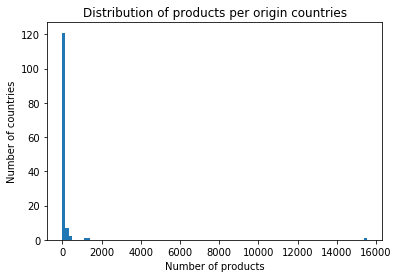

In [53]:
#Converting to Pandas
fr_origin_count_pd= fr_origin_count.toPandas()
countries_pd = countries.toPandas()

# Plot of the histogram
plt.hist(fr_origin_count_pd['count'], bins = 100)
plt.title('Distribution of products per origin countries')
plt.xlabel('Number of products')
plt.ylabel('Number of countries')
plt.show()

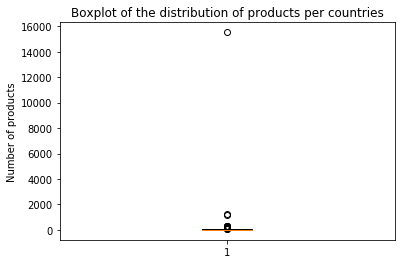

In [54]:
#Boxplot 
plt.boxplot(fr_origin_count_pd['count'])
plt.title('Boxplot of the distribution of products per countries')
plt.ylabel('Number of products')
plt.show()

In [55]:
# Computing number of products sold in France that have a known origin. 
n_tot_fr_with_origin = fr_origin_count_pd['count'].sum()
# Computing number of products sold in France that have a french origin. 
n_fr_origin_france = fr_origin_count_pd['count'][fr_origin_count_pd['cca3_ori']=='FRA'].values

print('There are', n_fr_origin_france, 'products sold in France that have a French origin.')
print( 'This reprensents',np.round(n_fr_origin_france/n_tot_fr_with_origin*100, 2), ' % of the products sold in France that have a known origin in the dataset.')

There are [15532] products sold in France that have a French origin.
This reprensents [67.16]  % of the products sold in France that have a known origin in the dataset.


>Most countries have very few products. However, we can also observe one big ouliers: France is once again over-represented in the dataset (with more than 15000 products coming from France, representing 67% of known origin). 

>This can be explained by multiple factors: 

>- We only selected products that are sold in France so it makes sense that more products have a French origin. 
>- The producers are more likely to indicate the origin on the product if it's make locally: this can be a selling argument. Therefore, we might have more French product sold in France also because companies who produce their merchendize far from France and then export it might be less transparent about it. 
>- The OpenFoodFact initiative was made for and by people that wants to eat healthier and 'eco-friendly' food. Therefore, a product that is made locally has more chance of being registered on the website. 

>Overall, this means that our dataset is not a representative sample of all food products available:  There is a biais that we have to consider for further analysis. 

>We then plotted the same histogram but this time, without French product to have a more detailed idea of the distribution of the origins. 

In [35]:
without_france =  fr_origin_count_pd[fr_origin_count_pd.cca3_ori!='FRA']

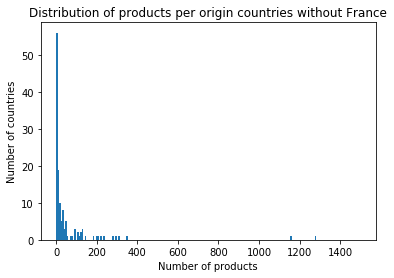

In [36]:
plt.hist(without_france['count'], bins = 200, range=(0,1500))
plt.title('Distribution of products per origin countries without France')
plt.xlabel('Number of products')
plt.ylabel('Number of countries')
plt.show()

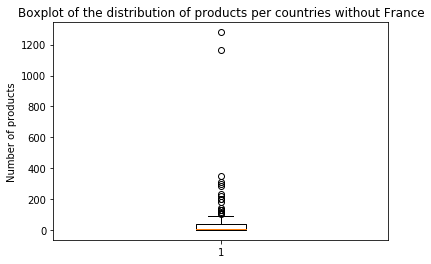

In [37]:
#Boxplot 
plt.boxplot(without_france['count'])
plt.title('Boxplot of the distribution of products per countries without France')
plt.ylabel('Number of products')
plt.show()

>Even without considering France, we can see that most countries export less than 100 products registered in the dataset in France.   
  
>We then decided to plot a log histogram as it seemed more appropriate for such a distribution. 

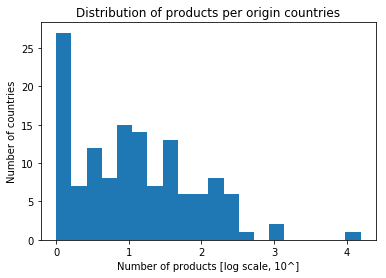

In [38]:
# Plot of the histogram in log scale
plt.hist(np.log10(fr_origin_count_pd['count']), bins = 20)
plt.title('Distribution of products per origin countries')
plt.xlabel('Number of products [log scale, 10^]')
plt.ylabel('Number of countries')
plt.show()

>Most countries of the dataset are registered in the 'origins' dataframe for only one product.  

### <font color=blue> Analysis of major origins for products sold in France </font>

>We then wanted to know which countries are exporting more products into France: This is reprensented by the following graphs (bar chart, pie chart). We also created a colormap for a better visual representation. 

In [39]:
# Creating new dataframes with interesting columns. 
origins_to_map = pd.DataFrame({'counts': fr_origin_count_pd['count'].values, 'alpha-3':fr_origin_count_pd['cca3_ori'].values})
countries_to_merge = pd.DataFrame({'counts': np.zeros(len(countries_pd)), 'alpha-3':countries_pd['cca3'].values}) 
                        
# Merging the two dataframe, order by counts, then drop the first duplicate 
# By merging the dataframes, some countries are duplicated, so by doing this, 
# You make sure that it's the one with count 0 that is dropped. 
origins_to_map = origins_to_map.append(countries_to_merge, ignore_index=True)
origins_to_map = origins_to_map.sort_values('counts').drop_duplicates('alpha-3', keep = "last")

# creating a Serie that can be used in the colormap
S_origins_to_map =pd.Series(origins_to_map['counts'].values, index=origins_to_map['alpha-3'].values).astype(int)

# Some countries are missing from the csv file --> We have to manually add them. 
Missing_index = ['NCYP','SOMA','CS-KM']
Missing = pd.Series(np.zeros(len(Missing_index)), index = Missing_index)
S_origins_to_map= S_origins_to_map.append(Missing)

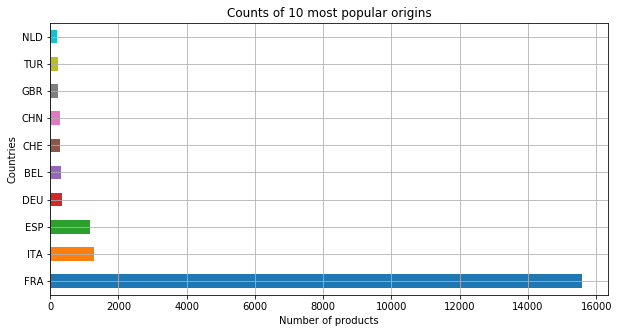

In [40]:
#Plot the counts of the 10 most popular tags
S_origins_to_map= S_origins_to_map.sort_values()
S_origins_to_map.tail(10).iloc[::-1].plot(kind = "barh", grid = True, figsize = (10,5))
plt.xlabel("Number of products")
plt.ylabel("Countries")
plt.title("Counts of 10 most popular origins")
plt.show()

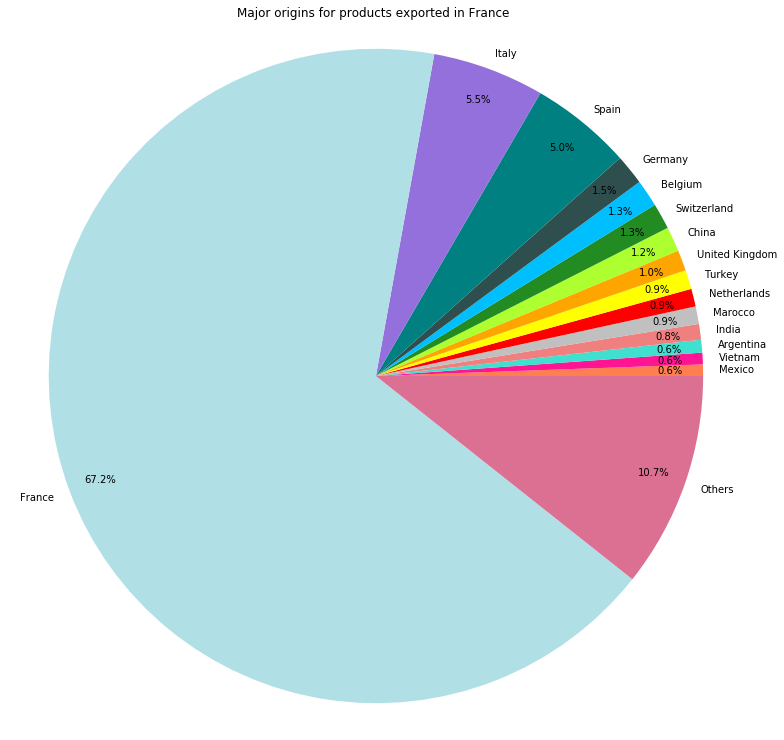

In [41]:
# Pie chart of the major exportator in France. 

# Computing the percentage for the 15 major origins
top_15_percentage = S_origins_to_map.tail(15).values/n_tot_fr_with_origin*100
# computing the 'others' percentage
rest = 100 - top_15_percentage.sum()
percentage_total= np.append(top_15_percentage, rest)

labels = 'Mexico','Vietnam','Argentina', 'India','Marocco', 'Netherlands', 'Turkey', 'United Kingdom', 'China', 'Switzerland', 'Belgium','Germany','Spain','Italy','France','Others'
sizes = percentage_total
colors_ = ['coral','deeppink', 'turquoise', 'lightcoral', 'silver', 'r', 'yellow', 'orange', 'greenyellow', 'forestgreen', 'deepskyblue', 'darkslategray', 'teal', 'mediumpurple', 'powderblue', 'palevioletred' ]

# Plot the pie chart
fig = plt.figure(figsize=[13, 13])
plt.pie(sizes, labels=labels, autopct='%1.1f%%', labeldistance= 1.05, colors = colors_, pctdistance= 0.9)
plt.axis('equal')
plt.title('Major origins for products exported in France')
plt.show()

>For the colormap: We used a JSON file of the world found online.
> In this JSON file, some countries had the same ID, and we had to change the Json file to make the map work: 
For northern cyprus: '-99' --> NCYP, For somalilia '-99'--> SOMA

In [42]:
# ColorMap

# loading a blank map 
Origins_map = folium.Map([0,0], tiles = 'cartodbpositron', zoom_start = 1.5)

# overlaying national borders
geo_json_data = json.load(open("data/countries.json"))

# defining the color scale
color_scale = branca.colormap.linear.Spectral_11.scale(0, 1500)
#color_scale = branca.colormap.linear.YlGnBu_09.scale(0, 1500)
#color_scale = branca.colormap.linear.YlOrRd_09.scale(0, 1500)
color_scale.caption = 'Number of products coming from the country'
Origins_map.add_child(color_scale)

# style function based on the color scale
def style_function(feature):
    #print(feature)
    value = S_origins_to_map.get(feature['id'])
    return {  
        'fillOpacity': 0.7,
        'weight': 0.7,
        'color': '#000000',
        'fillColor': '#708090' if (value==0) else color_scale(value)
    }

# adding the style function to the map
folium.TopoJson(
        geo_json_data,
        'objects.countries1',
        style_function = style_function,
        tooltip = folium.GeoJsonTooltip(['name'], labels = False, style = 'font-size:10px')
    ).add_to(Origins_map)

Origins_map.save("map.html")
Origins_map

>We can see in these different representations that the major origins exporting in France are European countries. Italy, Spain, Germany, Belgium and Switzerland, the top5 origins are all direct neighbours of France. However, once again, our dataset might biased by the fact that products that are more local are more registered in the dataset, and that companies producing near France are more transparent.     

>Therefore, in reality, they might be more products coming from other continents. China, for example, is also in the top 10 origins and could have a more important weight than the map shows

## <font color=green> Food categories</font>

>We can compare the difference between local French products and imported products. The food categories tags may be quite general, for example honey and chocolate could both be labeled as 'sugary-snacks' but chocolate is necessarily imported but honey may not. therefore, we will also focus on the product names.

### *What are the main categories of food products being imported?*

In [32]:
#most popular food categories sold in France
fr_category = local_french_products.groupBy('food_category').count().sort(desc("count"))

#most popular imported food categories
fr_import_category = fr_imported_products.groupBy('food_category').count().sort(desc("count"))

Text(0.5,1,'Counts of 20 first food categories imported in France')

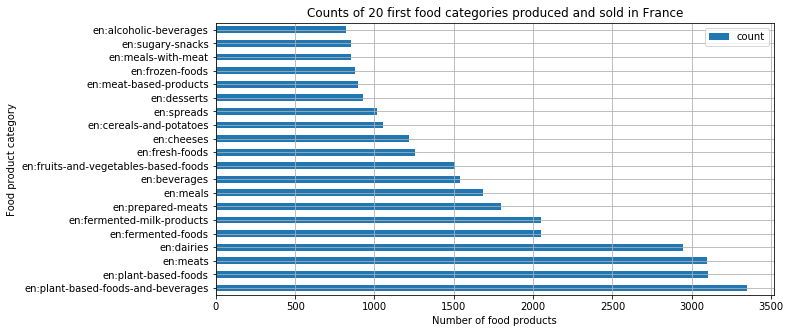

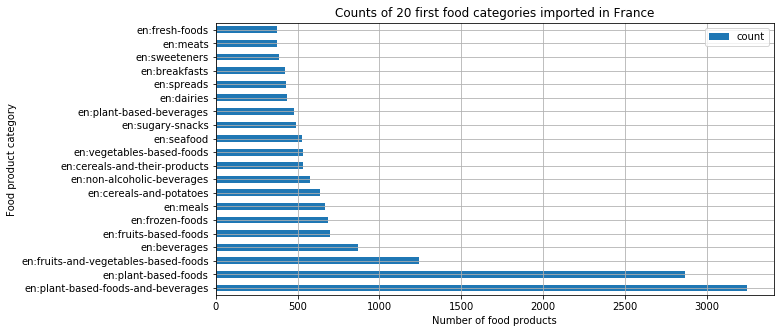

In [33]:
#Converting to Pandas the dataframe of French local products
fr_category_pd = fr_category.toPandas()
fr_category_pd.index=fr_category_pd.food_category
 
#show the 20 first food products produced and sold in France
fr_category_pd.head(20).plot(kind = "barh", grid = True, figsize = (10,5))
plt.xlabel("Number of food products")
plt.ylabel("Food product category")
plt.title("Counts of 20 first food categories produced and sold in France")

#Converting to Pandas
fr_import_category_pd = fr_import_category.toPandas()
fr_import_category_pd.index=fr_import_category_pd.food_category
 
#show the 20 first imported food products sold in France
fr_import_category_pd.head(20).plot(kind = "barh", grid = True, figsize = (10,5))
plt.xlabel("Number of food products")
plt.ylabel("Food product category")
plt.title("Counts of 20 first food categories imported in France")

>The most abundant local product sold in France are food and beverages based of plants. It is also the first category to be imported. It makes sense, as this category is very large and includes products which are necessarily imported as olive oil, tea, exotic fruits, coffee...
We can also observe that seafood for example is mainly imported and less produced locally.
Food categories are quite similar between local and imported products so displaying the product names can be more descriptive.


In [34]:
#most popular food products sold in France
fr_products = local_french_products.groupBy('product_name').count().sort(desc("count"))

#most popular imported food products
fr_import_products = fr_imported_products.groupBy('product_name').count().sort(desc("count"))

Text(0.5,1,'Counts of 20 first food products imported in France')

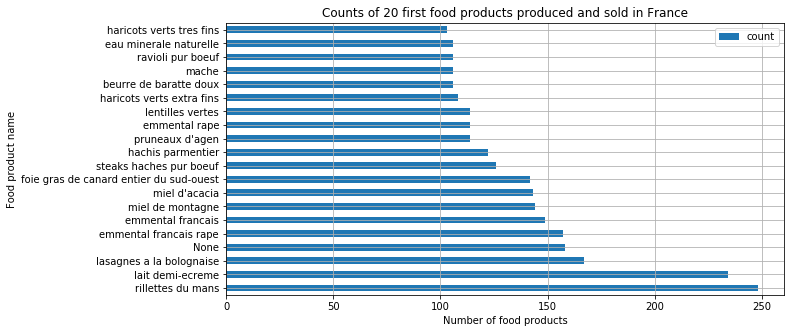

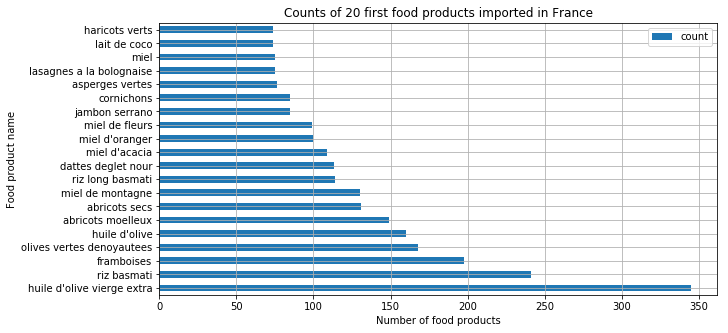

In [35]:
#Converting to Pandas the dataframe of French local products
fr_products_pd = fr_products.toPandas()
fr_products_pd.index=fr_products_pd.product_name
 
#show the 20 first local food products sold in France
fr_products_pd.head(20).plot(kind = "barh", grid = True, figsize = (10,5))
plt.xlabel("Number of food products")
plt.ylabel("Food product name")
plt.title("Counts of 20 first food products produced and sold in France")

#Converting to Pandas
fr_import_products_pd = fr_import_products.toPandas()
fr_import_products_pd.index=fr_import_products_pd.product_name
 
#show the 20 first imported food products sold in France
fr_import_products_pd.head(20).plot(kind = "barh", grid = True, figsize = (10,5))
plt.xlabel("Number of food products")
plt.ylabel("Food product name")
plt.title("Counts of 20 first food products imported in France")

> The most imported products sold in France can be produced in other European countries, except the dattes and coconut milk. Products such as olive oil and rice can come from Italy, and fruits like apricots and raspberries from other southern european countries when it is still not the season for them in France.
The first exportators to France are indeed european (Italy, Spain, Germany...). When considering the food product names, one may assume that the most imported products can easily be produced in France instead. 
As a very large part of the imported products come from european coutries, we do not see here products imported from very distant countries.

Now we will see which are the top imported food categories by countries.

In [36]:
#Group french products by origin and by food category
fr_products = fr_food_products.groupBy('food_category', 'cca3_ori').count() #get count per food category and origin

In [37]:
#Get the maximum imported food category per origin countries
max_import = fr_products.groupBy('cca3_ori')\
                        .agg(max(struct("count", "food_category")).alias('struct'))\
                        .select('cca3_ori', 'struct.food_category', 'struct.count')\
                        .show()



+--------+--------------------+-----+
|cca3_ori|       food_category|count|
+--------+--------------------+-----+
|     HTI|    en:sugary-snacks|    9|
|     PSE|en:plant-based-fo...|    3|
|     LVA|     fr:sprats-fumes|    1|
|     POL|     en:frozen-foods|   27|
|     JAM|    de:snacks-sucres|    1|
|     BRA|en:plant-based-fo...|    3|
|     MOZ|        en:smoothies|    1|
|     CUB|        en:beverages|    8|
|     FRA|en:plant-based-fo...| 3350|
|     BOL|en:plant-based-fo...|   52|
|     URY|            en:meals|   14|
|     ETH|            en:seeds|    1|
|     ITA|en:plant-based-fo...|  548|
|     UKR|en:plant-based-fo...|    6|
|     CMR|en:plant-based-fo...|    4|
|     GHA|    en:sugary-snacks|   15|
|     VIR|     en:frozen-foods|    1|
|     GTM|en:plant-based-fo...|   11|
|     SEN|en:plant-based-fo...|    4|
|     GUF|en:plant-based-fo...|    6|
+--------+--------------------+-----+
only showing top 20 rows



### *What is the distance distribution for the main imported food categories ?*

In [48]:
#Get distance statistics for 20 most imported categories
freq_imported_cat_list = freq_imported_categories_pd["food_category"].head(20).values
freq_imported_cat_list

array(['en:plant-based-foods-and-beverages', 'en:plant-based-foods',
       'en:fruits-and-vegetables-based-foods', 'en:beverages',
       'en:fruits-based-foods', 'en:frozen-foods', 'en:meals',
       'en:cereals-and-potatoes', 'en:non-alcoholic-beverages',
       'en:cereals-and-their-products', 'en:vegetables-based-foods',
       'en:seafood', 'en:sugary-snacks', 'en:plant-based-beverages',
       'en:dairies', 'en:spreads', 'en:breakfasts', 'en:sweeteners',
       'en:meats', 'en:fresh-foods'], dtype=object)

In [40]:
#convert into Pandas the dataframe with the most imported food categories
distances_freq_cat = pd.DataFrame(0, index=freq_imported_cat_list, 
                                  columns=["count","mean dist", 
                                           "std_dev", "min_dist", "Q_25", "median_dist", "Q_75","max_dist"])

#get the statistics of the distance travelled by each food category
for i, cat in enumerate(freq_imported_cat_list) :
    this_category_pd = category_distances.where(col("cca3_ori") != "FRA") \
                                        .filter(category_distances["food_category"] == cat) \
                                        .select("food_category", "dist_to_fr") \
                                        .toPandas()
    distances_freq_cat.iloc[i,:] = this_category_pd.describe().T.values[0].tolist()

distances_freq_cat.head(5)

,count,mean dist,std_dev,min_dist,Q_25,median_dist,Q_75,max_dist
en:plant-based-foods-and-beverages,3249.0,3922.026162,3786.159646,473.0,826.0,1471.0,8188.0,19161.0
en:plant-based-foods,2871.0,3746.173807,3736.990275,473.0,826.0,1458.0,7291.0,19161.0
en:fruits-and-vegetables-based-foods,1242.0,3203.269726,3344.368026,473.0,826.0,1090.0,6079.0,19161.0
en:beverages,868.0,4671.609447,4026.419406,473.0,826.0,2799.0,8597.0,19161.0
en:fruits-based-foods,700.0,3719.855714,3530.562640,473.0,826.0,2799.0,6691.0,19161.0


Text(0.5,1,'Mean, meadian and standard deviation of distance between France and the origin of food categories')

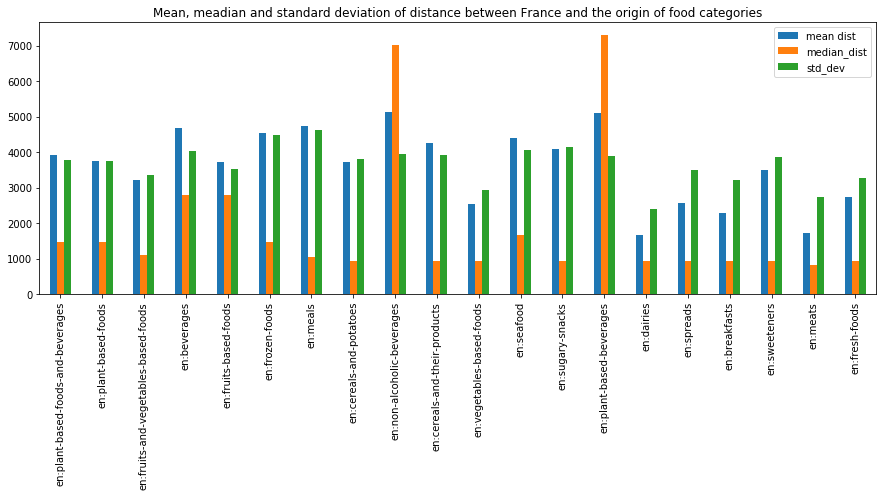

In [41]:
#plot the relevant statistics
distances_freq_cat[["mean dist","median_dist", "std_dev"]].plot(kind = 'bar', figsize=(15,5))
plt.title('Mean, meadian and standard deviation of distance between France and the origin of food categories')

>Most of the distance distributions for each food categories are not equally distributed as the median is often a lot smaller than the mean. This result means that for most food categories, the majority of the imports are done close to France (from Europe).  
> However, two categories stand out, having distances concentrated towards large values. 
These are :
    - Non alcoholic beverages
    - Plant-based beverages
which most likely regards tea and coffee importations.

In [69]:
#Dataframe of non alcoholic beverages sold in France coming from importation
far_beverages = category_distances.where(col("food_category") == 'en:non-alcoholic-beverages')\
                    .where(col("dist_to_fr") > 5000) \
                    .select("product_name", "cca3_ori")
far_beverages.show()

+--------------------+--------+
|        product_name|cca3_ori|
+--------------------+--------+
|        white koffie|     IDN|
|selection thes du...|     IND|
|     the vert sencha|     CHN|
|ceylon lemon tea ...|     HKG|
|the vert gunpowde...|     CHN|
|     the vert menthe|     CHN|
|             nescafe|     AUS|
|cafe capsules ken...|     KEN|
|the vert bio natu...|     LKA|
|           earl grey|     CHN|
|arabica moulu bol...|     BOL|
|      rooibos citron|     ZAF|
|       breakfast tea|     LKA|
|arabica moulu cos...|     CRI|
|planteur select c...|     COL|
|    chai authentique|     IND|
|     ceylon o.p. tea|     LKA|
|english breakfast...|     LKA|
|       original coco|     BRA|
| sommets de colombie|     COL|
+--------------------+--------+
only showing top 20 rows



> A quick overview of the products being in the "non-alcoholic-beverages" imported further than 5000km away indeed shows that tea and coffee are major products of such category.

In [70]:
far_beverages.groupby("cca3_ori").count().sort(desc("count")).show(10)

+--------+-----+
|cca3_ori|count|
+--------+-----+
|     CHN|   67|
|     LKA|   46|
|     IND|   33|
|     ZAF|   22|
|     MEX|   19|
|     COL|   14|
|     CRI|   11|
|     KEN|   11|
|     JPN|   10|
|     VNM|    7|
|     BOL|    7|
|     THA|    6|
|     CUB|    5|
|     PHL|    5|
|     MYS|    5|
|     UMI|    4|
|     LAO|    4|
|     GTM|    4|
|     MTQ|    4|
|     CAN|    3|
+--------+-----+
only showing top 20 rows



> China, Sri Lanka and India are the top 3 exporting countries for far importations of non-alcoholic beverages.
This is not suprising as those three countries are among the leaders in tea exportations.

Text(0.5,0.98,'Boxplots of the distance between France and the origin of the 10 most imported food categories')

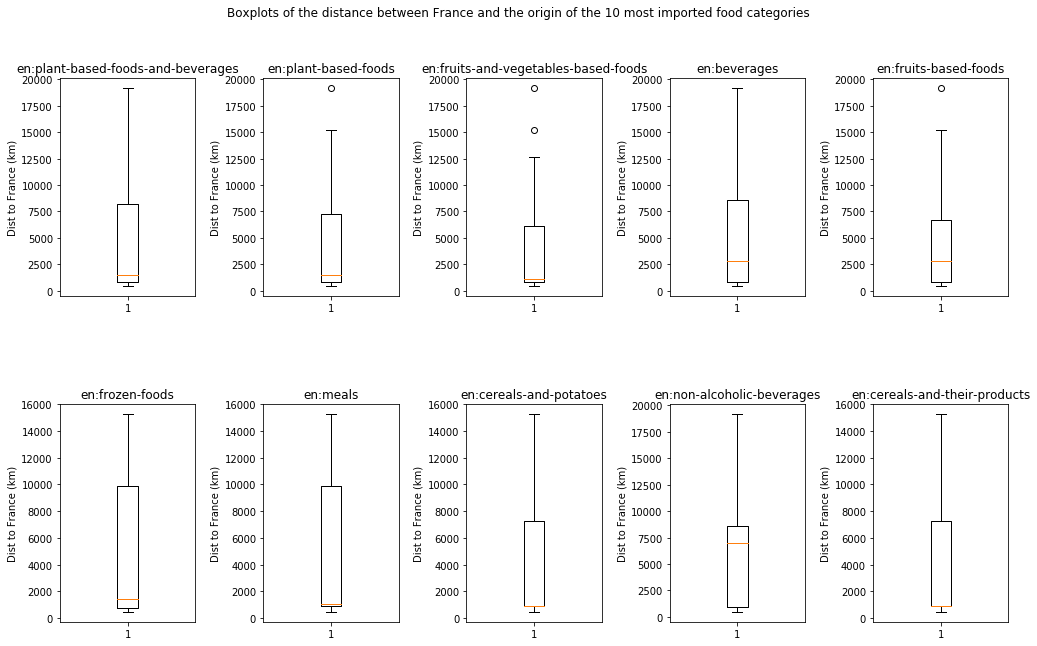

In [42]:
# Bootstrapping to get more insights into the distribution of the distances for the 10 first categories

#Set a figure of 2*5 subplots
fig, axs = plt.subplots(2,5, figsize=(17, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace= 0.5)
axs = axs.ravel()


#Iterate over the 10 most frequent imported categories
for i, cat in enumerate(freq_imported_cat_list[0:10]) :
    
    #Get the origins different from France and collect the distances for the food category considered
    this_category_pd = category_distances.where(col("cca3_ori") != "FRA") \
                                        .filter(category_distances["food_category"] == cat) \
                                        .select("food_category", "dist_to_fr") \
                                        .toPandas()
    
    #Calculate a boxplot of the distribution based on bootstrapping outcomes
    axs[i].boxplot(this_category_pd.dist_to_fr, bootstrap=1000)
    axs[i].set_title(cat)
    axs[i].set_ylabel("Dist to France (km)")

plt.suptitle('Boxplots of the distance between France and the origin of the 10 most imported food categories')

> Here, the boxplot resulting from boostrapping display the median and its 95% confidence interval. 
If it is below 5000km for most categories, it is around 7500km for non-alcoholic beverages as stated previously. 
Not many categories have outliers, meaning that the importation distances are quite balanced among the respective countries for the food category considered

# End of Milestone 2

### How the project has evolved since milestone 1

- Abandon on the Machine Learning tasks : Even though this seemed to be a very interesting idea, the biais in the data will give biaised prediction outputs. We will then focus more on :
    * What are the main importation countries for France ?
    * For those countries, what are the top food categories exported ?
    * What is the correlation between distance travelled and the packaging used ? (or any other relevant features, but we were not able to find any other)    
      
- Focus on product sold in France : if we want our datastory to have a guideline it is easier and clearer to have a country to focus on. As the French products are the most represented in the dataset, and having at least half of their origins labelled, France make a good candidate for our importation analysis.

- We also considered comparing French and US importations as US product are the second most represented in the dataset. However, their origins are poorly labelled and would yield good statistics.

- Initial plan was to use the carbon-footprint to study its correlation with distance. However this feature is poorly labelled (as very hard to know) and would not be relevant. Using Packaging type is another alternative that could show that products imported for foreign countries may have more packaging, maybe harder to recycle...  
  


### Plan for the data story
- We will do our datastory on Jekyll and making visualisations using D3. 
- We are planning to do 2 and maybe 3 types of visualisations, but this is still under debate and might evolve in the following weeks :
    * An interactive map where each country will show its top food category exported to France, and the strength of the connexion with France (related to the count of products). 
    * An interactive map that shows the distances as arcs between countries and shows what are the main packaging used. Including manufacturing places might be relevant here.  
    * An interactive plot, that shows for a given food category the food products (as dots), the packaging used (y axis), the distance travelled (x axis). Clicking on a dot would display product image and link to the product page. Issue with this visualisation is that packaging is not a continuous values. Initial plan was here to use the carbon footprint which is continuous. 
    
    
### Plan for the Poster
Poster will most likely contains a pie-chart of the top food categories imported in France, and a graphic showing the relationship between distance and packaging type. A graphic showing the distance traveled by particular food products or food categories as meat and beverages would also be interesting, to show the impact of our daily consommation of such products.
This still remains to be further defined.


In [43]:
#Carbon foot print not very labelled
data.where(col("carbon-footprint_100g").isNull() == False).count()

343

In [44]:
#Packaging type much more annotated
data.where(col("packaging_tags").isNull() == False).count()

139023

# Part of Notebook to be completed by milestone 3

### Study of the correlation between Packaging type and distance travelled

In [ ]:
#TODO

### Bootstrapping to get share of top food category for most represented exportators

In [ ]:
#TODO

### Analysis of top 10-20 food categories imported (is this justified?)

In [ ]:
#TODO

### Other data analysis could be required depending on the outcomes of the previous steps.

In [ ]:
#TODO